In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score,
                           precision_score,
                           recall_score,
                           f1_score,
                           roc_curve,
                           auc,
                           roc_auc_score)
from sklearn.base import is_classifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


# Data Exploration and Preprocessing

In [52]:
df = pd.read_csv('card_transdata.csv', index_col=0)
df.head()

,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,,,,,,,
57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 57.87785658389723 to 58.10812496080576
Data columns (total 7 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_last_transaction  1000000 non-null  float64
 1   ratio_to_median_purchase_price  1000000 non-null  float64
 2   repeat_retailer                 1000000 non-null  float64
 3   used_chip                       1000000 non-null  float64
 4   used_pin_number                 1000000 non-null  float64
 5   online_order                    1000000 non-null  float64
 6   fraud                           1000000 non-null  float64
dtypes: float64(7)
memory usage: 61.0 MB


data looks like it have no null values

In [54]:
df.describe()

,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Summary and Insights

#### 1. `distance_from_last_transaction`
- The average distance/time between transactions is approximately **5 units** (units not specified in the Kaggle dataset).
- The standard deviation is high compared to the mean, indicating a **wide spread** in values.
- The median is **under 1 unit**, meaning that **50% of transactions occurred within 1 unit** of distance/time.
- This column is **heavily right-skewed**, as most values are low but a few are very high (mean = 5.04 > median).

#### 2. `ratio_to_median_purchase_price`
- On average, transaction amounts are **1.82 times the median purchase price**.
- This column is also **right-skewed** (mean > median).
- Most transactions are relatively **close to the median price**, but there are some **significant high-value outliers** (maximum value = 267.803).

---

### Binary Feature Overview

#### 3. `repeat_retailer`
- A binary column with a mean of **0.8815**, indicating that **88.15% of transactions are from repeat customers**.

#### 4. `used_chip`
- A binary column with a mean of **0.3504**, meaning that **35.04% of transactions used a card chip**.

#### 5. `used_pin_number`
- A binary column with a mean of **0.1006**, showing that only **10.06% of transactions used a PIN number**.

#### 6. `online_order`
- A binary column with a mean of **0.6506**, indicating that **approximately 65% of transactions were online orders**.

---

### Target Variable

#### 7. `fraud`
- A binary column used for **classification**.
- The mean is **0.0874**, indicating a **high class imbalance** — only **8.74% of transactions are fraudulent**.

Binary columns will now be converted into boolean for memory efficiency, semantic clarity and potential performance increase

In [55]:
binary_columns = {'repeat_retailer': 'bool',
                  'used_chip': 'bool',
                  'used_pin_number': 'bool',
                  'online_order': 'bool',
                  'fraud': 'bool'
                  }

df = df.astype(binary_columns)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 57.87785658389723 to 58.10812496080576
Data columns (total 7 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_last_transaction  1000000 non-null  float64
 1   ratio_to_median_purchase_price  1000000 non-null  float64
 2   repeat_retailer                 1000000 non-null  bool   
 3   used_chip                       1000000 non-null  bool   
 4   used_pin_number                 1000000 non-null  bool   
 5   online_order                    1000000 non-null  bool   
 6   fraud                           1000000 non-null  bool   
dtypes: bool(5), float64(2)
memory usage: 27.7 MB


,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,,,,,,,
57.877857,0.311140,1.945940,True,True,False,False,False
10.829943,0.175592,1.294219,True,False,False,False,False
5.091079,0.805153,0.427715,True,False,False,True,False
2.247564,5.600044,0.362663,True,True,False,True,False
44.190936,0.566486,2.222767,True,True,False,True,False
...,...,...,...,...,...,...,...
2.207101,0.112651,1.626798,True,True,False,False,False
19.872726,2.683904,2.778303,True,True,False,False,False
2.914857,1.472687,0.218075,True,True,False,True,False


For the continous columns, a box plot will be plotted to see how much the data is skew and the outliers



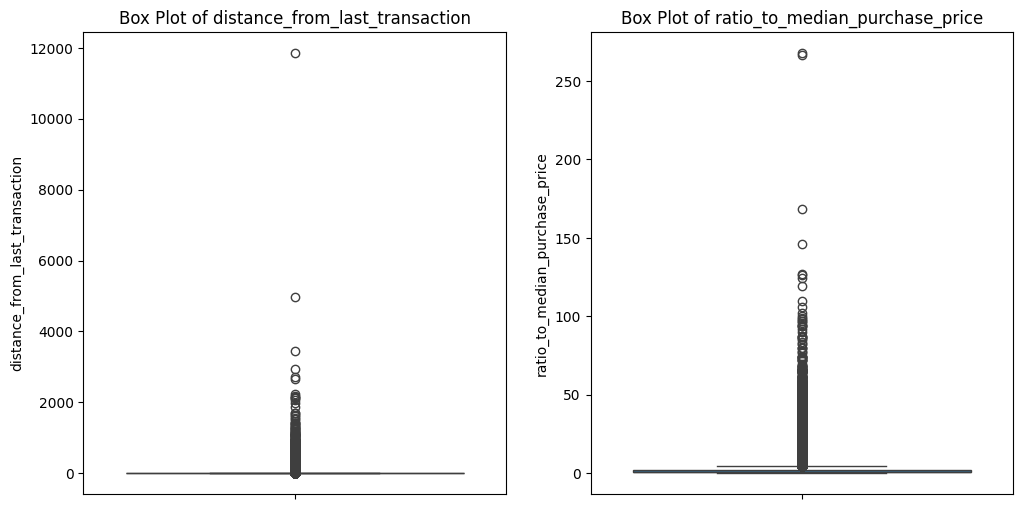

In [56]:
continuous_cols = ['distance_from_last_transaction', 'ratio_to_median_purchase_price']

fig, axes = plt.subplots(1, len(continuous_cols), figsize=(12, 6))

if len(continuous_cols) == 1:
    axes = [axes]

for i, col_name in enumerate(continuous_cols):
    sns.boxplot(y=df[col_name], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col_name}')
    axes[i].set_ylabel(col_name)
    axes[i].set_xlabel('')

# plt.tight_layout()
plt.show()


The box plot shows that for both  `distance_from_last_transaction` and `ratio_to_median_purchase_price`:



*   Most values are tightly grouped
*   There is a tail of much larger values that strecth the distrinution to the far right.


---


For now the outliers will be left in as the outliers may be indicators to fraud.


## Correlation matrix


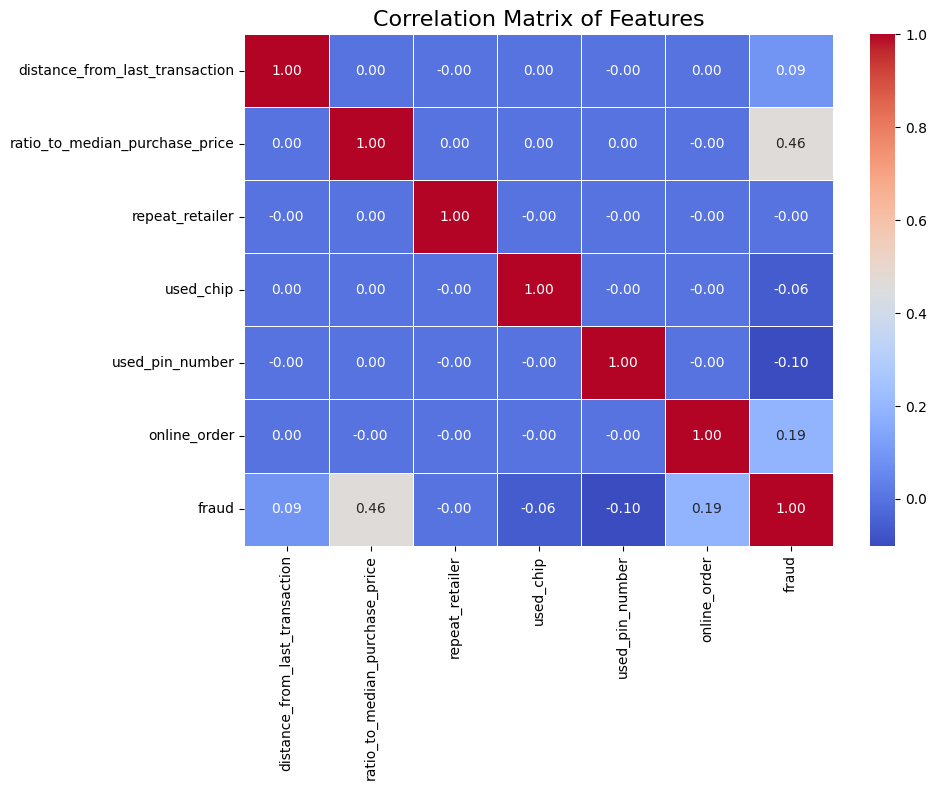

In [57]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
    # You can add vmin=-1, vmax=1 if you want the color scale fixed from -1 to 1
)

plt.title('Correlation Matrix of Features', fontsize=16)

plt.tight_layout()
plt.show()

### Correlation Insights

From the correlation matrix, it appears that `ratio_to_median_purchase_price` has the **strongest positive correlation** with fraud, followed by `online_order`. On the other hand, `used_chip` and `used_pin_number` show **negative correlations** with fraud.

Intuitively, this makes sense:
- If a purchase is **abnormally high compared to the median purchase price**, it is more likely to be **fraudulent**.
- Many fraudulent transactions tend to be **online orders**, which explains the positive correlation with `online_order`.
- Conversely, **using a chip or a PIN number** provides an additional layer of authentication, making the transaction **less likely to be fraudulent** — hence the negative correlation.

These insights align well with typical fraud patterns observed in financial transactions.


# Machine Learning Algorithms



In [58]:
def evaluate_classification_model(model, model_name, X_test, y_test):
    # --- Predictions ---
    y_pred = model.predict(X_test)
    roc_auc = float('nan')

    # --- Probability/Score Predictions (for ROC AUC) ---
    try:
        # Try predict_proba first
        if hasattr(model, "predict_proba") and callable(model.predict_proba):
            y_scores = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_scores)
        # If predict_proba fails or doesn't exist, try decision_function
        elif hasattr(model, "decision_function") and callable(model.decision_function):
            y_scores = model.decision_function(X_test)
            # Ensure y_scores is 1D (sometimes decision_function might output differently)
            if y_scores.ndim > 1:
                 # Handle multi-class case if necessary, here assuming binary and taking one column
                 if y_scores.shape[1] > 1:
                      print(f"Warning: decision_function returned {y_scores.shape[1]} columns for {model_name}. Using column 1 for ROC AUC.")
                      y_scores = y_scores[:, 1]
                 else: # If shape is (n, 1), flatten it
                      y_scores = y_scores.ravel()

            roc_auc = roc_auc_score(y_test, y_scores)
            print(f"Info: Used decision_function() for ROC AUC ({model_name}).")
        else:
            # Neither method is available
            print(f"Warning: Model '{model_name}' supports neither predict_proba() nor decision_function(). ROC AUC set to NaN.")

    except Exception as e:
        # Catch any other errors during score calculation
        print(f"Error calculating ROC AUC for {model_name}: {e}. ROC AUC set to NaN.")
        roc_auc = float('nan')


    # --- Calculate Other Metrics ---
    accuracy = accuracy_score(y_test, y_pred)
    # Set zero_division=0 to return 0 if denominator is zero (no true/predicted positives)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # --- Store Results in a Dictionary ---
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

In [59]:
def plot_roc_curve(model, X_test, y_test, model_name):
    # Check if the model supports probability prediction
    if not (hasattr(model, "predict_proba") and callable(model.predict_proba)):
        print(f"Model '{model_name}' does not support predict_proba(). Cannot plot ROC curve.")
        # You might want to check for decision_function as an alternative for some models like SVC
        if hasattr(model, "decision_function") and callable(model.decision_function):
             print("Trying decision_function() instead...")
             try:
                 y_scores = model.decision_function(X_test)
             except Exception as e:
                 print(f"Could not use decision_function: {e}")
                 return # Exit if neither works
        else:
            return # Exit if neither predict_proba nor decision_function is available

    else:
        # Get predicted probabilities for the positive class (usually class 1)
        y_scores = model.predict_proba(X_test)[:, 1]


    # Calculate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    # Alternatively using roc_auc_score: roc_auc = roc_auc_score(y_test, y_scores)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'{model_name} (AUC = {roc_auc:.3f})') # Format AUC to 3 decimal places
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance') # Diagonal line

    # Formatting the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) # Slightly higher limit to see the top border
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Test/Train Split

In [60]:
X = df.drop(columns=["fraud"])
y = df["fraud"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
y_train.value_counts()

models_result = pd.DataFrame()

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 57.87785658389723 to 58.10812496080576
Data columns (total 7 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_last_transaction  1000000 non-null  float64
 1   ratio_to_median_purchase_price  1000000 non-null  float64
 2   repeat_retailer                 1000000 non-null  bool   
 3   used_chip                       1000000 non-null  bool   
 4   used_pin_number                 1000000 non-null  bool   
 5   online_order                    1000000 non-null  bool   
 6   fraud                           1000000 non-null  bool   
dtypes: bool(5), float64(2)
memory usage: 27.7 MB


In [62]:
X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 3.426737313631301 to 50.17837925716929
Data columns (total 6 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_last_transaction  800000 non-null  float64
 1   ratio_to_median_purchase_price  800000 non-null  float64
 2   repeat_retailer                 800000 non-null  bool   
 3   used_chip                       800000 non-null  bool   
 4   used_pin_number                 800000 non-null  bool   
 5   online_order                    800000 non-null  bool   
dtypes: bool(4), float64(2)
memory usage: 21.4 MB
<class 'pandas.core.series.Series'>
Index: 800000 entries, 3.426737313631301 to 50.17837925716929
Series name: fraud
Non-Null Count   Dtype
--------------   -----
800000 non-null  bool 
dtypes: bool(1)
memory usage: 6.9 MB


## Logistic Regression

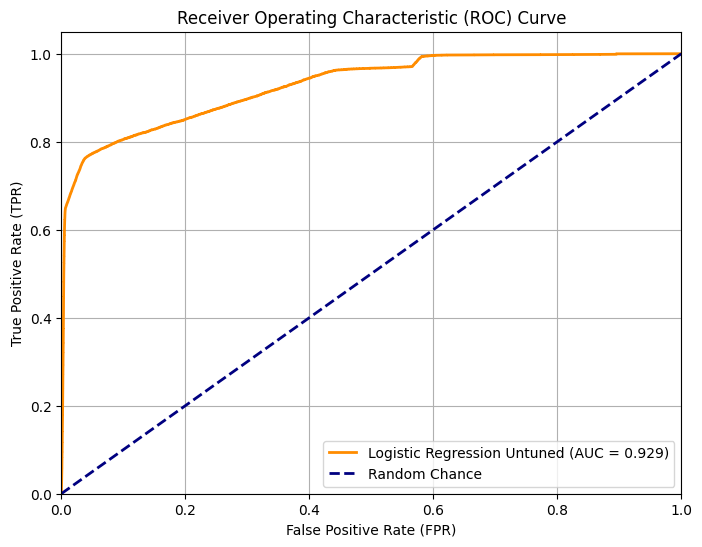

In [63]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_results = evaluate_classification_model(lr, 'Logistic Regression Untuned', X_test, y_test)
models_result = pd.concat([models_result, lr_results])
models_result
plot_roc_curve(lr, X_test, y_test, 'Logistic Regression Untuned')

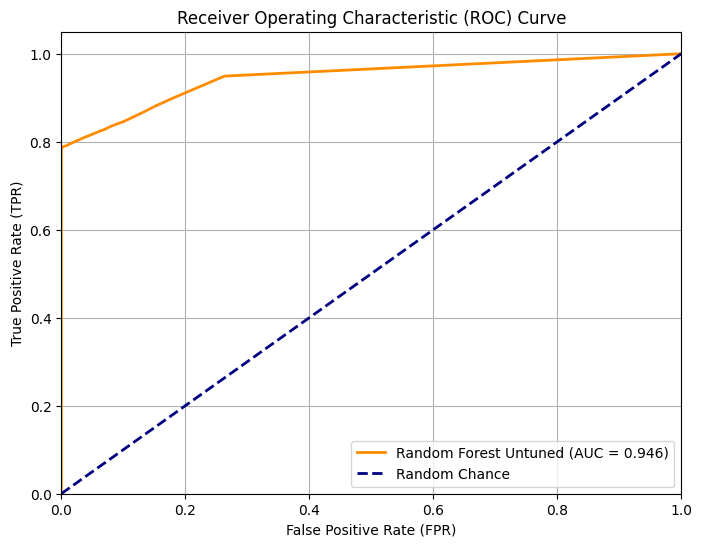

In [64]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_results = evaluate_classification_model(rf, 'Random Forest Untuned', X_test, y_test)
models_result = pd.concat([models_result, rf_results])
models_result
plot_roc_curve(rf, X_test, y_test, 'Random Forest Untuned')

Info: Used decision_function() for ROC AUC (SVM Untuned).
Model 'SVM Untuned' does not support predict_proba(). Cannot plot ROC curve.
Trying decision_function() instead...


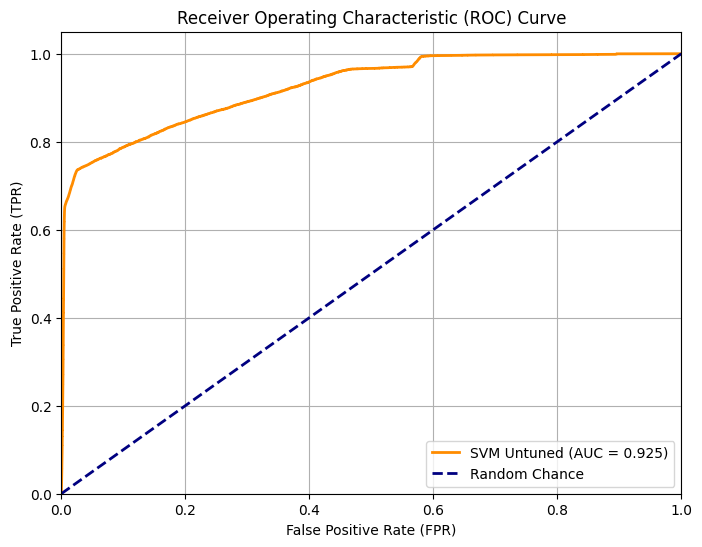

In [65]:
lsvc=LinearSVC(dual=False, random_state=42, max_iter=2000) # Increased max_iter slightly
lsvc.fit(X_train, y_train)

svm_results = evaluate_classification_model(pipeline_linearsvc, 'SVM Untuned', X_test, y_test)
models_result = pd.concat([models_result, svm_results])
models_result
plot_roc_curve(lsvc, X_test, y_test, 'SVM Untuned')

TODO:
test with scaling
scaling and smote
no scaling and smote
hyperamter tune all variation for each model